# Easy21 - Prediction

EP01 from class of Planning MAC5788 - IME-USP
This assignment is based on the Easy21 from David Silver class:

### Game Rules
- The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
- At the start of the game both the player and the dealer draw one black card (fully observed).
- Each turn the player may either stick or hit.
- If the player hits then she draws another card from the deck.
- If the player sticks she receives no further cards.
- The values of the player’s cards are added (black cards) or subtracted (red cards).
- If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1).
- If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

##### Implementation of Easy21 simulator
You should write an environment that implements the game Easy21. Specifically, write a function, named STEP, which takes as **input a state s** (dealer’s first card 1–10 and the player’s sum 1–21), **and an action a** (hit or stick), and returns a sample of the next state s′ (which may be terminal if the game is finished) and reward r. We will be using this environment for prediction and for control (in the next part of this EP) and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [72]:
import random
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

HIT = 0
STICK = 1
RED = 'red'
BLACK = 'black'
TERMINAL_STATE = "end"


class State:
    dealer = random.randint(1, 10)
    player = random.randint(1, 10)


class Policy:

    def get_action(self, state):
        pass


class RandomPolicy(Policy):

    def get_action(self, state):
        return random.randint(0,1)

class PolicyHitUntil19(Policy):
    
    def get_action(self, state):
        return HIT if state <= 19 else STICK 

class Easy21Env:

    def __init__(self, seed=-1, policy=RandomPolicy()):
        if seed != -1:
            random.seed(seed)
        self.policy = policy

    @staticmethod
    def get_card():
        return random.randint(1, 10)

    @staticmethod
    def get_color():
        return RED if random.random() < 1 / 3 else BLACK

    def draw(self, state):
        card = self.get_card()
        if self.get_color() == BLACK:
            state += card
        else:
            state -= card

        return state

    def step(self, state, action):
        if action == HIT:
            state.player = self.draw(state.player)
            if state.player < 1 or state.player > 21:
                return TERMINAL_STATE, -1.0
            else:
                return state, 0.0
        else:
            while state.dealer < 17:
                state.dealer = self.draw(state.dealer)
                if state.dealer < 1 or state.dealer > 21:
                    return TERMINAL_STATE, 1.0

            if state.dealer > state.player:
                return TERMINAL_STATE, -1.0
            elif state.dealer == state.player:
                return TERMINAL_STATE, 0.0
            else:
                return TERMINAL_STATE, 1.0

    def create_episodes(self, number_of_episodes=1000):
        episodes = []

        for current_episode in range(number_of_episodes):
            state = State()
            state.player = random.randint(1, 10)
            state.dealer = random.randint(1, 10)
            episode = []

            while state != TERMINAL_STATE:
                action = self.policy.get_action(state.player)
                dealer = state.dealer
                player = state.player

                new_state, reward = self.step(state, action)
                episode.append((dealer, player, action, reward))
                
                state = new_state

            episodes.append(episode)


        return episodes

In [73]:
def plot_v_function(value, name):
    fig = plt.figure()
    sliced_value = value[1:, 1:]
    plt.imshow(sliced_value, cmap='jet')
    plt.ylabel('Dealer card')
    plt.xlabel('Player card')
    plt.xticks(np.arange(21)+1)
    plt.yticks(np.arange(10)+1)
    plt.gca().invert_yaxis()
    fig.suptitle(name)
    plt.colorbar()
    
    plt.show()
    
def plot_wire(value, name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = range(10)
    y = range(21)
    X, Y = np.meshgrid(y, x)
    ax.plot_wireframe(Y+1, X+1, value[1:, 1:])
    ax.set_xlabel('Dealer Cards')
    ax.set_ylabel('Player Card')
    ax.set_zlabel(r'$v_{\pi}$')
    fig.suptitle(name)
    
    plt.show()


First of all, we will generate the episodes that will be used thoughout the project.

In [74]:
easy21env = Easy21Env(seed=21, policy=PolicyHitUntil19())
episodes = easy21env.create_episodes(number_of_episodes=1000000)

easy21env2 = Easy21Env(seed=21)
episodes_random_policy = easy21env2.create_episodes(number_of_episodes=100000)

#### Monte Carlo Prediction

In [75]:
def monte_carlo_prediction(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None):
    for episode in episodes:
        g = 0
        for dealer, player, action, reward in episode:
            g += reward

        for dealer, player, action, reward in episode:
            n[dealer, player] += 1
            a = 1 / n[dealer, player]
            v[dealer, player] = v[dealer, player] + a * (g - v[dealer, player])

    return v, n

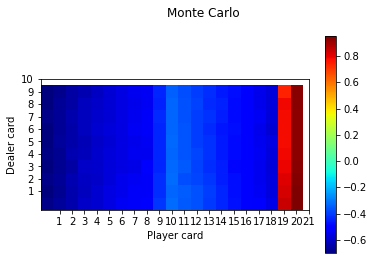

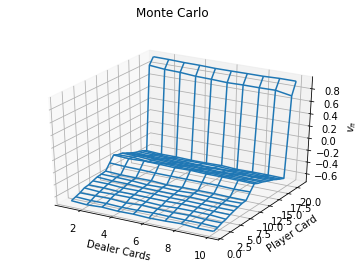

In [76]:
mc_value, counter = monte_carlo_prediction(episodes=episodes)
plot_v_function(mc_value, 'Monte Carlo')
plot_wire(mc_value, 'Monte Carlo')

#### TD(0) Prediction

In [77]:
def td0(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None):
    for episode in episodes:
        for current_index in range(len(episode)):            
            dealer, player, action, reward = episode[current_index]
            n[dealer, player] += 1

            a = 1 / n[dealer, player]

            if current_index+1 < len(episode):
                next_dealer, next_player, _, _ = episode[current_index+1]

                v[dealer, player] = v[dealer, player] + a * (
                            reward + v[next_dealer, next_player] - v[dealer, player])
            else:
                v[dealer, player] = v[dealer, player] + a * (
                        reward + 0 - v[dealer, player])
                
    return v, n

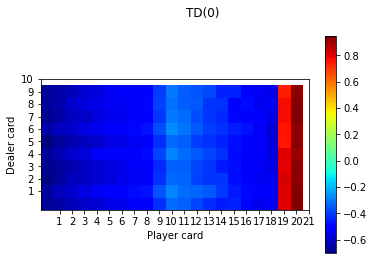

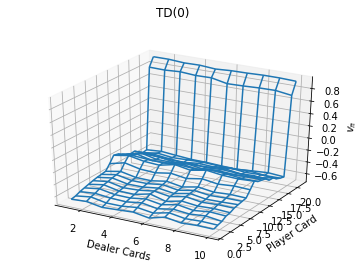

In [78]:
valuetd0, counter = td0(episodes=episodes[:100000])
plot_v_function(valuetd0, 'TD(0)')
plot_wire(valuetd0, 'TD(0)')

In [79]:
def td(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None, scaling=0):
    for episode in episodes:
        for j in range(len(episode)):
            dealer, player, action, reward = episode[j]
            reward_sum = 0
            g_total = 0
            maxstep = (len(episode) - j)
                        
            for next_index in range(maxstep):
                lookaheadstate = next_index + j
                dealer1, player1, _, reward1 = episode[lookaheadstate]
                
                if lookaheadstate == (maxstep - 2): 
                    dealer2, player2, _, _ = episode[lookaheadstate+1]
                    nextstatevalue = v[dealer2, player2]
                
                    reward_sum = reward_sum + reward1
                    g = reward_sum + nextstatevalue

                    if (maxstep - 1) == next_index:
                        g_total += math.pow(scaling, next_index) * g
                    else:
                        g_total += (1.0 - scaling) * math.pow(scaling, next_index) * g
                else:
                    nextstatevalue = 0
                
                    reward_sum = reward_sum + reward1
                    g = reward_sum + nextstatevalue

                    if (maxstep - 1) == next_index:
                        g_total += math.pow(scaling, next_index) * g
                    else:
                        g_total += (1.0 - scaling) * math.pow(scaling, next_index) * g

            n[dealer, player] += 1
            a = 1.0 / n[dealer, player]
            v[dealer, player] = v[dealer, player] + a * (g_total - v[dealer, player])

    return v, n

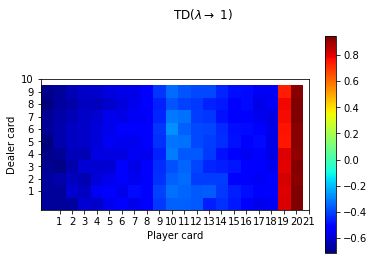

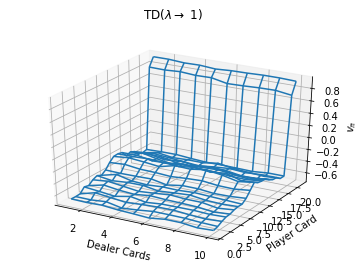

In [80]:
lam = 1
valuetde, counter = td(episodes=episodes[:100000], scaling=lam)
plot_v_function(valuetde, r'TD($\lambda \rightarrow$ {value_l})'.format(value_l=lam))
plot_wire(valuetde, r'TD($\lambda \rightarrow$ {value_l})'.format(value_l=lam))


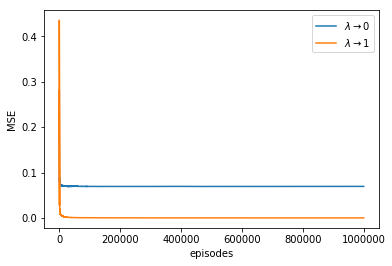

In [81]:

msq = np.zeros((2,len(episodes)))
for k in range(2):
    td_value = np.zeros((11,22))
    td_counter = np.zeros((11,22))
    for i, episode in enumerate(episodes):
        td_value, td_counter = td(td_value, td_counter, [episode], scaling=k*1)
        msq[k, i] = np.sum(np.square(mc_value - td_value)) / (11*22)
        
plt.plot(np.arange(len(episodes)), msq[0],label=r'$\lambda \rightarrow 0$')
plt.plot(np.arange(len(episodes)), msq[1],label=r'$\lambda \rightarrow 1$')
plt.ylabel("MSE")
plt.xlabel("episodes")
plt.legend()

plt.show()

- What are the pros and cons of bootstrapping in Easy21:prediction?

The cons of using bootstrapping is the bias introduce by the initial values, since you're using the values availables. The pro is that you don't have to wait until the end of the episode to have a value.

- Would you expect bootstrapping to help more in blackjack or Easy21:prediction? Why?

Bootstrapping will help more on the Easy21 since the episodes can be longer due to the RED cards.

- Verify that TD($\lambda \rightarrow 0$) equivalent to TD(0)


In [82]:
v_td0, counter = td0(episodes=episodes)
# v_td_lam_0, counter = td(episodes=episodes, scaling=0)

mse_td0 = np.sum(np.square(mc_value - v_td0)) / (11*22)
print("{:.20f}".format(mse_td0 - msq[0, len(episodes) - 1]))


-0.06928864648149199446


Eventhough the TD($\lambda \rightarrow$ 1), convergers to 0-MSE when compared to Monte Carlo, the same thing did not happen when comparing TD(0) against TD($\lambda \rightarrow$ 1), which means that probably there some error in the implementation of either of these algorithms.

- Verify that TD($\lambda \rightarrow 1$) equivalent to MC

As it follow the Mean square error from the TD($\lambda \rightarrow 1$) is equal zero when compared against Monte Carlo

In [83]:
print(msq[1, len(episodes) -1])

0.0


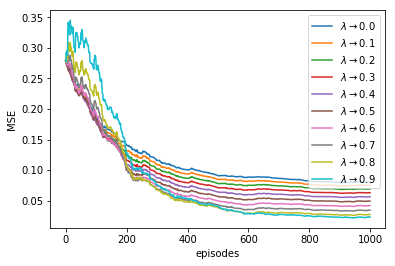

In [84]:
msq = np.zeros((10,len(episodes[:1000])))
for k in range(10):
    td_value = np.zeros((11,22))
    td_counter = np.zeros((11,22))
    for i in range(len(episodes[:1000])):
        td_value, td_counter = td(td_value, td_counter, [episodes[i]], k*0.1)
        msq[k, i] = np.sum(np.square(mc_value - td_value)) / (11*22)
    
    plt.plot(np.arange(len(episodes[:1000])), msq[k],label=r'$\lambda \rightarrow {lam:.1f}$'.format(lam=k*0.1))

plt.ylabel("MSE")
plt.xlabel("episodes")
plt.legend()

plt.show()

In [85]:
lam = 1
td_lam_1, counter = td(episodes=episodes, scaling=lam)

print(np.sum(np.square(mc_value - td_lam_1)) / (11*22))

2.8168847685421882e-06


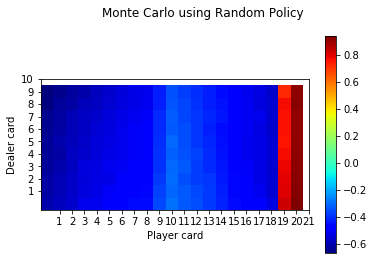

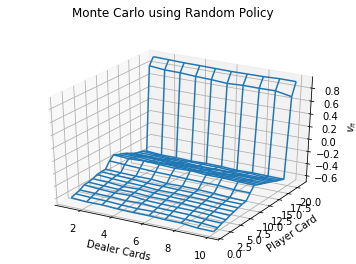

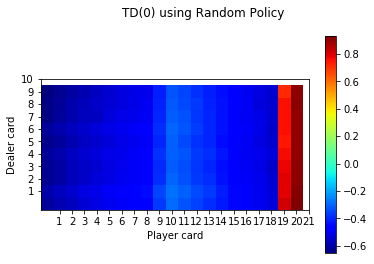

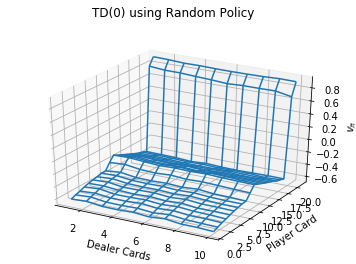

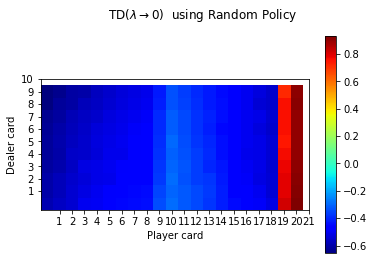

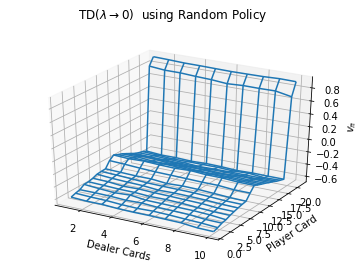

In [91]:
v_mc_random, _ = monte_carlo_prediction(episodes=episodes_random_policy)
plot_v_function(v_mc_random, "Monte Carlo using Random Policy")
plot_wire(v_mc_random, "Monte Carlo using Random Policy")


v_td0_random, _ = td0(episodes=episodes_random_policy)
plot_v_function(v_td0_random, "TD(0) using Random Policy")
plot_wire(v_td0_random, "TD(0) using Random Policy")


v_tdl_random, _ = td(episodes=episodes_random_policy, scaling=1)
plot_v_function(v_tdl_random, r'TD($\lambda \rightarrow 0$)  using Random Policy')
plot_wire(v_tdl_random, r'TD($\lambda \rightarrow 0$)  using Random Policy')



In [87]:
def td_el(v=np.zeros((11, 22)), n=np.zeros((11, 22)), episodes=None, scaling=0):
    for episode in episodes:        
        E = {}
        for j in range(len(episode)):
            dealer, player, _, reward = episode[j]
            if j+1 < len(episode):
                new_dealer, new_player, _, _ = episode[j+1]
                error = reward + v[new_dealer, new_dealer] - v[dealer, player]
                
                if (dealer, player) in E:
                    E[(dealer, player)] = E.get((dealer, player)) + 1
                else:
                    E[(dealer, player)] = 1
                    
                n[dealer, player] += 1
                
                for j in E:
                    dealer1, player1 = j
                    alpha = 1/n[dealer1, player1]
                    v[dealer1, player1] = v[dealer1, player1] + (alpha * error * E[j])
                    E[j] = E[j] * scaling
            else:
                error = reward - v[dealer, player]
                
                if (dealer, player) in E:
                    E[(dealer, player)] = E.get((dealer, player)) + 1
                else:
                    E[(dealer, player)] = 1
                    
                n[dealer, player] += 1
                
                for j in E:
                    dealer1, player1 = j
                    alpha = 1/(n[dealer1, player1])
                    v[dealer1, player1] = v[dealer1, player1] + alpha * error * E[j]
                    E[j] = E[j] * scaling
            
    return v, n

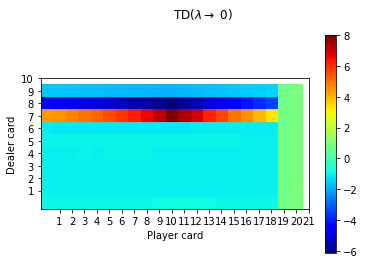

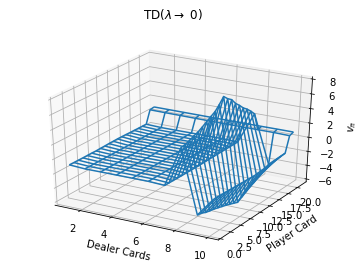

In [90]:
lam = 0
value_le, counter = td_el(episodes=episodes, scaling=lam)
plot_v_function(value_le, r'TD($\lambda \rightarrow$ {value_l})'.format(value_l=lam))
plot_wire(value_le, r'TD($\lambda \rightarrow$ {value_l})'.format(value_l=lam))